In [1]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2023, 10)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.*, stocks.stock_name as name from month_chart
    join stocks on month_chart.code = stocks.stock_code
    where year(date) >= {begin.year}
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지
    df1 = df1[df1["val_last"] > 1_0000_0000]  # 거래량 1억 이상(거래량 적을 시 매수 실패할거라고 가정)

    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0) | (df2["val_last"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "시가총액": df1["cap"],
        "거래량": df1["vol"],
        "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "val": df1["val"],
        "val_last": df1["val_last"],
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    fn_sep = fs_loader.load(settled_qtr.year, settled_qtr.qtr, 0)
    fn_sep.columns = ["sep_" + col for col in fn_sep.columns]
    layer1 = pd.concat([layer1, df.join(fn).join(fn_sep)])

layer1.reset_index(inplace=True)
layer1.to_csv(".analysis/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

layer1 = pd.read_csv(".analysis/layer1.csv", dtype={"code": str})
layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1 = layer1[layer1["확정실적"].notna()]
layer1

,code,매수년월,매도년월,종목명,매수일,매수가,시가총액,거래량,거래대금,전월수익률,...,sep_R/A_QoQ,sep_R/EQ_QoQ,sep_GP/A_QoQ,sep_GP/EQ_QoQ,sep_O/A_QoQ,sep_O/EQ_QoQ,sep_EBT/A_QoQ,sep_EBT/EQ_QoQ,sep_E/A_QoQ,sep_E/EQ_QoQ
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,064260,2014-04,2014-05,다날,2014-04-30,10100.0,2.063363e+11,19577010.0,2.160986e+11,-0.133047,...,0.006118,0.012601,0.006118,0.012601,-0.000585,-0.000973,0.031489,0.058377,0.029841,0.055276
65,001810,2014-04,2014-05,무림SP,2014-04-30,3135.0,6.940106e+10,6101825.0,1.867097e+10,0.144161,...,-0.007497,-0.018161,-0.006286,-0.010604,0.008386,0.012673,-0.010245,-0.016243,-0.008999,-0.014192
66,060560,2014-04,2014-05,홈센타홀딩스,2014-04-30,2615.0,7.097781e+10,4889251.0,1.354574e+10,-0.069395,...,-0.021532,-0.030904,0.004396,0.006290,-0.004200,-0.006018,-0.005678,-0.008135,-0.001654,-0.002371
67,105840,2014-04,2014-05,우진,2014-04-30,8050.0,1.397480e+11,445266.0,3.631067e+09,-0.020681,...,-0.008822,-0.004427,0.019127,0.024698,0.015531,0.019424,0.015571,0.019600,0.009883,0.012650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200911,096610,2023-09,2023-10,알에프세미,2023-09-27,9270.0,1.466157e+11,6830717.0,8.108752e+10,-0.421709,...,-0.043295,-0.204366,-0.022579,-0.039592,-0.010866,0.015177,-0.029397,-0.018766,-0.006243,0.028617
200912,085660,2023-09,2023-10,차바이오텍,2023-09-27,18330.0,1.032244e+12,27531699.0,5.674048e+11,0.040295,...,0.008956,0.016349,0.004635,0.008364,0.001720,0.002528,0.074909,0.111599,0.078266,0.116888
200913,042670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,0.006945,-0.180091,0.017134,0.006302,0.017692,0.028277,0.014757,0.020343,0.010612,0.013974
200914,054620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,0.001601,0.002333,0.000167,0.000237,-0.003945,-0.005778,0.018090,0.026494,0.013505,0.019778


In [3]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P"
    }
)

factors = [col for col in layer1.columns if col.endswith("QoQ")]
factors += ["P"]

# 가격비율
layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
factors.append("EQ/P")

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    factor = f"{col}/P"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["P"]
    factors.append(factor)

    # 자산비율
    factor = f"{col}/A"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["A"]
    factors.append(factor)

    # 자본비율
    factor = f"{col}/EQ"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["EQ"]
    factors.append(factor)

    # 이익율
    factor = f"{col}/R"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["R/Y"]
    factors.append(factor)

# =============================================
# 별도 재무제표 팩터 계산
# factors += [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
# layer2["sep_EQ/P"] = layer2["sep_EQ"] / layer2["P"]
# factors.append("sep_EQ/P")
# for col in is_cols:
#     factor = f"sep_{col}/P"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["P"]
#     factors.append(factor)
# 
#     # 자산비율
#     factor = f"sep_{col}/A"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["sep_A"]
#     factors.append(factor)
# 
#     # 자본비율
#     factor = f"sep_{col}/EQ"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["sep_EQ"]
#     factors.append(factor)
# 
#     # 이익율
#     factor = f"sep_{col}/R"
#     layer2[factor] = layer2[f"sep_{col}/Y"] / layer2["sep_R/Y"]
#     factors.append(factor)
# =============================================

recipes = {
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "퀄리티": {
        "GP/EQ": 0.081688,
        "GP/A": 0.068516,
        "O/A": 0.059149,
        "O/R": 0.056152,
        "O/EQ": 0.054418,
        "R/EQ": 0.053285,
        "EBT/A": 0.042171,
        "EBT/R": 0.035214,
        "GP/R": 0.034800,
        "EBT/EQ": 0.034718
    },
    "성장": {
        "GP/A_QoQ": 0.142706,
        "O/A_QoQ": 0.130182,
        "GP/EQ_QoQ": 0.129825,
        "O/EQ_QoQ": 0.118514,
        "E/EQ_QoQ": 0.111300,
        "O_QoQ": 0.098340,
        "E_QoQ": 0.097314,
        "GP_QoQ": 0.083276,
        "R/A_QoQ": 0.082624,
        "E/A_QoQ": 0.079270,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
        "퀄리티": 0.5
    }
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    # 개별 팩터 백분위 계산
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(pct=True) * 100)

    # 별도 재무제표 팩터 백분위 반영
    # for factor in factors:
    #     if not factor.startswith("sep_") and f"sep_{factor}" in factors:
    #         df[f"{factor}_pct"] = np.ceil(df[[f"sep_{factor}_pct", f"{factor}_pct"]].mean(axis=1))

    # 혼합 팩터 계산
    for title, recipe in recipes.items():
        df[title] = sum([df[f"{k}_pct"] * w for k, w in recipe.items()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(pct=True) * 100)

    result = pd.concat([result, df])

result

2023-10

,code,매수년월,매도년월,종목명,매수일,매수가,P,거래량,거래대금,전월수익률,...,E/EQ_pct,E/R_pct,벨류,벨류_pct,퀄리티,퀄리티_pct,성장,성장_pct,전략,전략_pct
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,064260,2014-04,2014-05,다날,2014-04-30,10100.0,2.063363e+11,19577010.0,2.160986e+11,-0.133047,...,26.0,26.0,105.0,53.0,29.659555,59.0,64.300828,60.0,76.5,50.0
65,001810,2014-04,2014-05,무림SP,2014-04-30,3135.0,6.940106e+10,6101825.0,1.867097e+10,0.144161,...,50.0,60.0,178.0,94.0,22.089153,35.0,49.536326,46.0,129.5,84.0
66,060560,2014-04,2014-05,홈센타홀딩스,2014-04-30,2615.0,7.097781e+10,4889251.0,1.354574e+10,-0.069395,...,37.0,43.0,104.0,52.0,14.122514,17.0,60.718000,57.0,88.5,58.0
67,105840,2014-04,2014-05,우진,2014-04-30,8050.0,1.397480e+11,445266.0,3.631067e+09,-0.020681,...,37.0,59.0,71.0,30.0,13.538300,16.0,92.244986,93.0,77.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200911,096610,2023-09,2023-10,알에프세미,2023-09-27,9270.0,1.466157e+11,6830717.0,8.108752e+10,-0.421709,...,9.0,7.0,18.0,6.0,3.106636,1.0,35.856283,28.0,-11.5,9.0
200912,085660,2023-09,2023-10,차바이오텍,2023-09-27,18330.0,1.032244e+12,27531699.0,5.674048e+11,0.040295,...,21.0,22.0,93.0,47.0,20.818122,33.0,82.587237,83.0,58.5,37.0
200913,042670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,92.0,71.0,129.0,67.0,42.901217,95.0,89.913985,90.0,110.5,73.0
200914,054620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,40.0,78.0,97.0,49.0,12.174374,14.0,46.988587,42.0,49.0,32.0


[4/4] 전략티2014-04 2023-10


,spearman,kendall,h10,t10,h10-t10,mean,median,strength
전략,0.886949,0.721616,0.255162,-0.123215,0.378378,0.049043,0.034926,0.335602
벨류,0.724356,0.534949,0.121450,-0.085148,0.206598,0.042893,0.043281,0.149650
성장,0.752943,0.566061,0.139561,-0.015359,0.154920,0.046518,0.055300,0.116646
퀄리티,0.247261,0.157980,0.038890,-0.032961,0.071851,0.045480,0.047198,0.017766


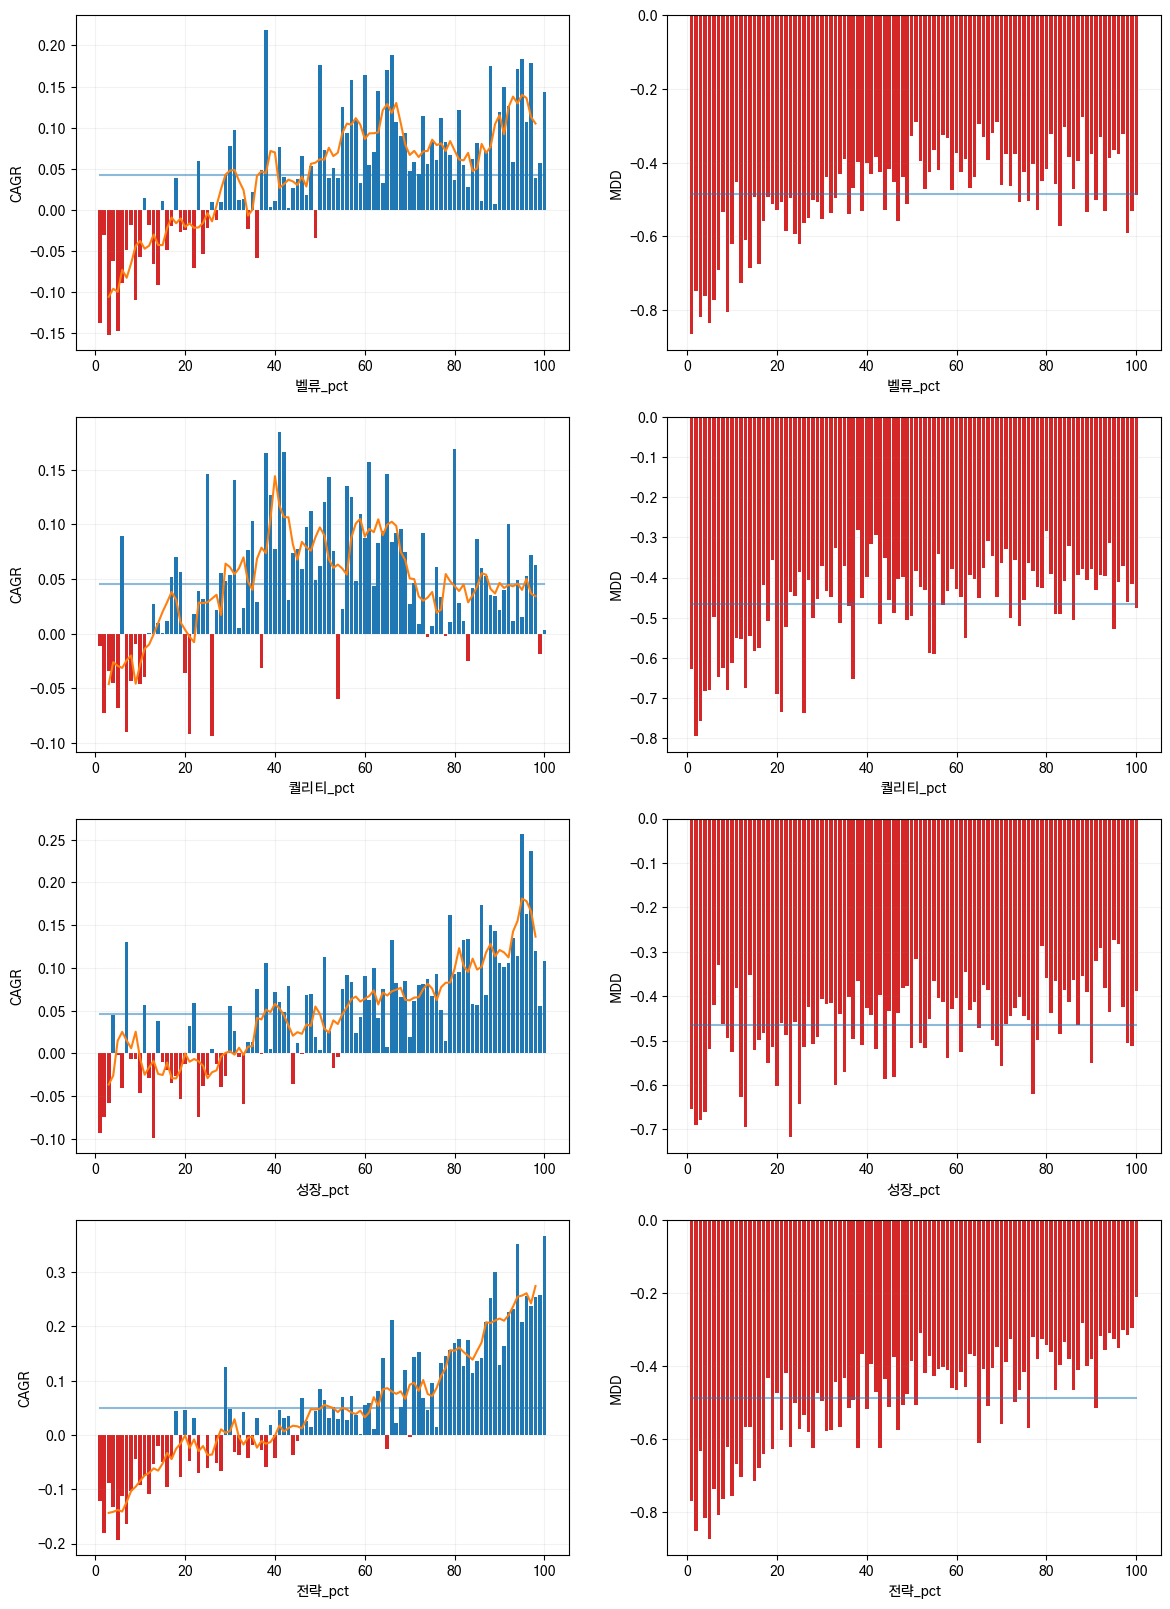

In [4]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr, mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(14), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = result[colname].dropna().sort_values().unique()
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    cagr_by_pct, mdd_by_pct = pd.Series(cagr_by_pct), pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(pd.Series(pcts), [cagr_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr_by_pct.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(pd.Series(pcts), [mdd_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct[cagr_by_pct.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct[mdd_by_pct.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["h10-t10"]

print(result["매수년월"].min(), result["매도년월"].max())
summary = summary.sort_values(by="strength", ascending=False)
summary

In [5]:
# 백테스트

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

result2 = result.copy()[result[factor].notna()]

result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

port_size = 20
port = result2.groupby(_key).apply(lambda x: x.sort_values("전략", ascending=False).head(port_size))
strategy = port.reset_index(drop=True).groupby(_key)["수익률"].mean()
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "BM 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": strategy - benchmark,
    "BM 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod(),
})

running_max = revisions["BM 누적수익률"].cummax()
revisions["BM DD"] = (revisions["BM 누적수익률"] - running_max) / running_max

running_max = revisions["전략 누적수익률"].cummax()
revisions["전략 DD"] = (revisions["전략 누적수익률"] - running_max) / running_max

revisions = revisions.dropna()

years = len(revisions) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["BM 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["BM 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["BM 수익률"].mean()]
}, index=["전략", "BM"])
print(summary)


result3 = port.reset_index(drop=True).groupby(_key).apply(lambda x: x.sort_values("수익률", ascending=False))[[
    "code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "consolidated",
    "P_pct", "성장_pct", "벨류_pct", "퀄리티_pct", f"{factor}_pct"
]]
result3 = result3.reset_index(drop=True)
result3.to_csv(".analysis/port.csv")
result3

전략
        CAGR                                         MDD      Mean
전략  0.401554  (-0.24502876594908807, (2022-04, 2022-09))  0.031598
BM  0.048336   (-0.3674258518414856, (2018-05, 2020-03))  0.005877


,code,종목명,수익률,매수일,매도일,매수가,매도가,consolidated,P_pct,성장_pct,벨류_pct,퀄리티_pct,전략_pct
0,120030,조선선재,0.272158,2014-04-30,2014-05-30,47950.0,61000.0,0.0,23.0,98.0,53.0,92.0,98.0
1,051630,진양화학,0.218310,2014-04-30,2014-05-30,2840.0,3460.0,0.0,8.0,93.0,59.0,87.0,99.0
2,024940,PN풍년,0.103774,2014-04-30,2014-05-30,2120.0,2340.0,0.0,3.0,93.0,92.0,55.0,100.0
3,003310,대주산업,0.029008,2014-04-30,2014-05-30,655.0,674.0,1.0,3.0,69.0,95.0,31.0,98.0
4,014200,광림,0.028571,2014-04-30,2014-05-30,1925.0,1980.0,0.0,10.0,97.0,87.0,29.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,038010,제일테크노스,-0.074214,2023-09-27,2023-10-31,7950.0,7360.0,1.0,18.0,95.0,79.0,94.0,100.0
2276,053270,구영테크,-0.091065,2023-09-27,2023-10-31,2910.0,2645.0,1.0,22.0,99.0,76.0,85.0,100.0
2277,031820,콤텍시스템,-0.104457,2023-09-27,2023-10-31,718.0,643.0,1.0,26.0,85.0,94.0,81.0,99.0
2278,900260,로스웰,-0.126794,2023-09-27,2023-10-31,836.0,730.0,1.0,2.0,98.0,94.0,18.0,100.0


In [6]:
revisions.to_csv(".analysis/revisions.csv")
revisions

,,BM 수익률,전략 수익률,성능,BM 누적수익률,전략 누적수익률,BM DD,전략 DD
매수년월,매도년월,,,,,,,
2014-04,2014-05,-0.008505,-0.010113,-0.001608,0.991495,0.989887,0.000000,0.000000
2014-05,2014-06,-0.008698,0.028109,0.036807,0.982871,1.017712,-0.008698,0.000000
2014-06,2014-07,0.014296,0.012081,-0.002215,0.996923,1.030006,0.000000,0.000000
2014-07,2014-08,0.040334,0.062192,0.021858,1.037132,1.094064,0.000000,0.000000
2014-08,2014-09,0.012084,0.080119,0.068035,1.049665,1.181720,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-05,2023-06,0.008392,0.082663,0.074272,1.865186,27.998401,-0.221545,0.000000
2023-06,2023-07,-0.027836,-0.047541,-0.019705,1.813266,26.667325,-0.243214,-0.047541
2023-07,2023-08,0.016717,0.000995,-0.015722,1.843579,26.693872,-0.230563,-0.046593


total            114.000000
out-perform       79.000000
under-perform     35.000000
승률                 0.692982
누적 성능             15.520240
dtype: float64

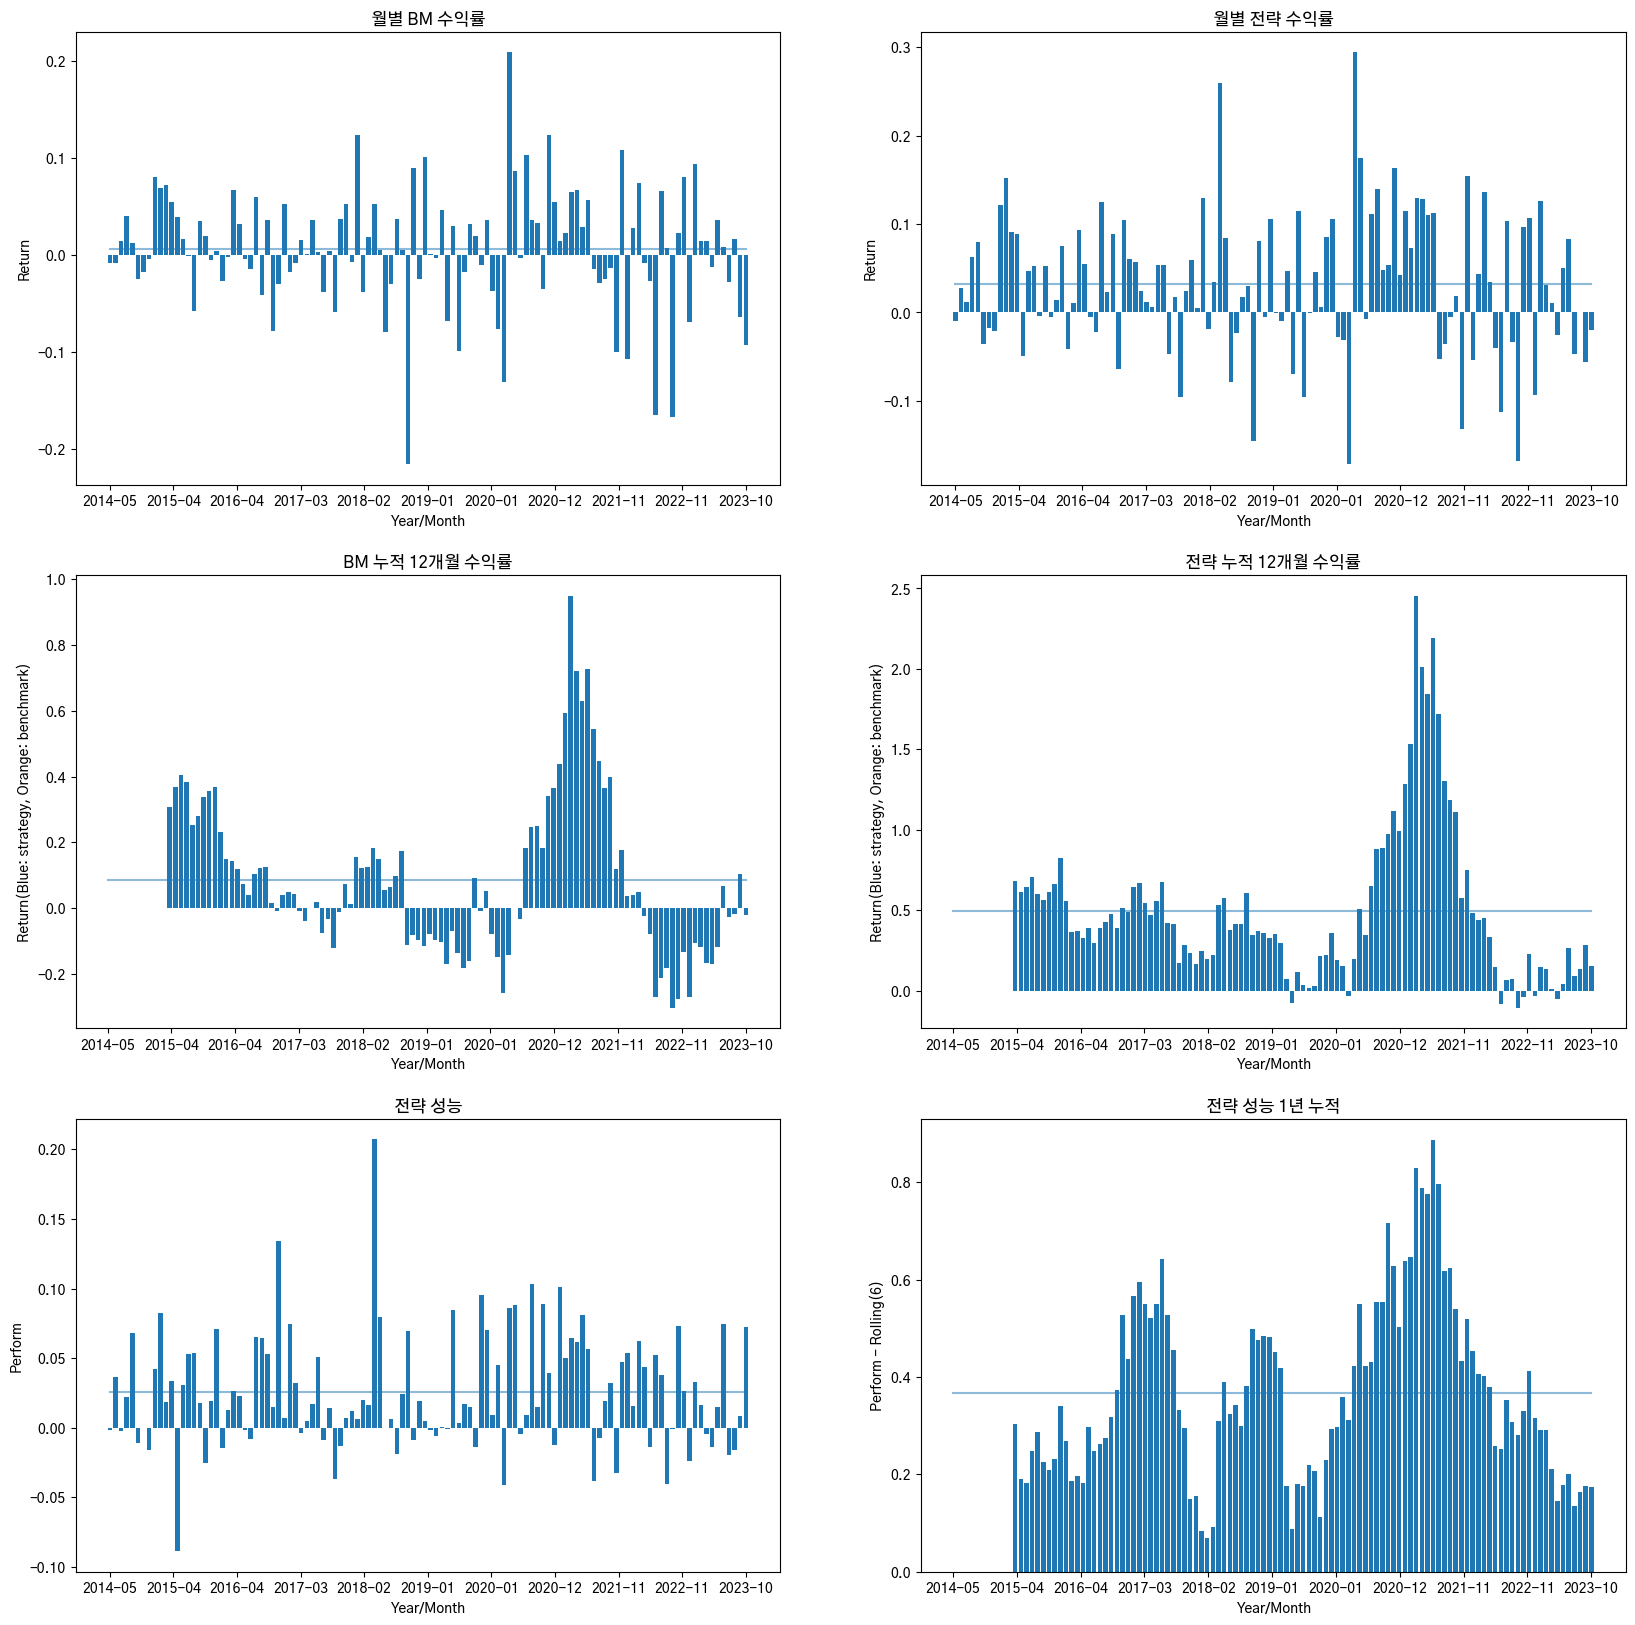

In [7]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 BM 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["BM 수익률"])
ax1.plot(months, [revisions["BM 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"BM 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["BM 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": (revisions["성능"] > 0).sum(),
    "under-perform": (revisions["성능"] < 0).sum(),
    "승률": (revisions["성능"] > 0).sum() / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})

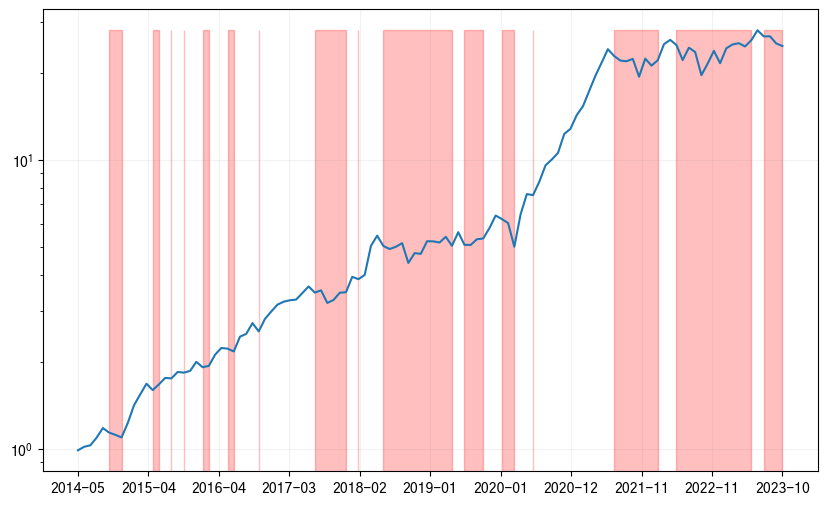

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 예시 생성
x_values = months
y_values = revisions["전략 누적수익률"]
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.yscale('log')
plt.xticks(np.quantile(np.arange(0, len(revisions)), xticks))
plt.grid(True)
plt.fill_between(
x_values, y_values.max(),
where = (revisions["전략 DD"] < 0),
color = "red", alpha = 0.25
)